In [1]:
from rag.load import load_benchmark_corpus, corpus_to_texts_metadatas


benchmark, corpus = load_benchmark_corpus()
texts, metadatas = corpus_to_texts_metadatas(corpus)
text = texts[0]

## Examine RCTS Chunker

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


def get_document_span(doc):
    start = doc.metadata['start_index']
    return (start, start + len(doc.page_content))

text_splitter = RecursiveCharacterTextSplitter(
    separators=['\n\n', '\n', '!', '?', '.', ':', ';', ',', ' ', ''],
    chunk_size=500,
    chunk_overlap=0,
    add_start_index=True,
)

documents = text_splitter.create_documents([text])
rcts_spans = [get_document_span(doc) for doc in documents]
print(f'RCTS spans: {len(rcts_spans)}')

RCTS spans: 64


In [3]:
import statistics


def print_spans(spans, buffer=200, limit=5):
    lengths = [end - start for start, end in spans]
    mean, median, max_ = statistics.mean(lengths), statistics.median(lengths), max(lengths)
    print(f"Count: {len(spans)}, Mean Length: {mean:.2f}, Median Length: {median}, Max Length: {max_}\n")
    for i, (start, end) in enumerate(spans[:limit]):
        chunk = text[start:end]
        print (f"Chunk #{i} (length={len(chunk)})")
        if len(chunk) < 2 * buffer:
            print(chunk.strip())
            print("\n")
        else:
            print (chunk[:buffer].strip())
            print ("...")
            print (chunk[-buffer:].strip())
            print ("\n")

print_spans(rcts_spans)

Count: 64, Mean Length: 395.25, Median Length: 412.0, Max Length: 497

Chunk #0 (length=170)
At Fiverr we care about your privacy.
We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.


Chunk #1 (length=354)
We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.


Chunk #2 (length=478)
We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser
...
more personalized browsing experience.
  We will not share information that you provide us in the process of the registration - 

## Examine Semantic Chunker

### Examiner Initial Splitter

In [4]:
import re


def split_to_spans(pattern, text):
    spans = []
    start = 0
    for match in re.finditer(pattern, text):
        spans.append((start, match.start()))
        start = match.end()
    if start < len(text):
        spans.append((start, len(text)))
    return spans

newline_spans = split_to_spans(r'\n\s*', text)
print_spans(newline_spans)

Count: 173, Mean Length: 145.10, Median Length: 127, Max Length: 567

Chunk #0 (length=39)
At Fiverr we care about your privacy.


Chunk #1 (length=132)
We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.


Chunk #2 (length=354)
We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.


Chunk #3 (length=316)
We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser information and cookies to enable you to have a better user experience and a more personalized browsing experi

### Window and Embed Sentences

In [5]:
from sentence_transformers import SentenceTransformer
from transformers import BitsAndBytesConfig

def window_spans(spans, pad):
    combined_spans = []
    for i in range(len(spans)):
        start = spans[max(0, i - pad)][0]
        end = spans[min(len(spans) - 1, i + pad)][1]
        combined_spans.append((start, end))
    return combined_spans

def pairwise_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        distances.append(1 - embeddings[i] @ embeddings[i + 1])
    return distances

model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-8B",
    model_kwargs={"quantization_config": BitsAndBytesConfig(load_in_8bit=True)}
)

windowed_spans = window_spans(newline_spans, pad=2)
embeddings = model.encode([text[start:end] for start, end in windowed_spans])
distances = pairwise_cosine_distances(embeddings)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Visualize embeddings

In [6]:
%matplotlib inline

import statistics

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_groups(spans, distances, chunks):
    # plot distances
    plt.figure(figsize=(12, 6))
    sns.lineplot(distances);
    
    # set bounds
    y_upper = 1.1 * max(distances)
    plt.xlim(0, len(distances))
    plt.ylim(0, y_upper)
    
    # draw chunks
    colors = sns.color_palette('colorblind')
    
    lengths = []
    for i, (start, end) in enumerate(chunks):
        if start > 0:
            start -= 1
        if end < len(distances):
            end -= 1
        plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.3, label=f'Chunk {i}')
        lengths.append(spans[end - 1][1] - spans[start][0])
    mean = statistics.mean(lengths)
    median = statistics.median(lengths)
    
    plt.title(f'Sentence Chunks (Count: {len(lengths)}, Mean/Median/Max Length: {mean:.2f} / {median} / {max(lengths)})')
    plt.xlabel('Sentence Index')
    plt.ylabel('Cosine Distance')
    plt.show()

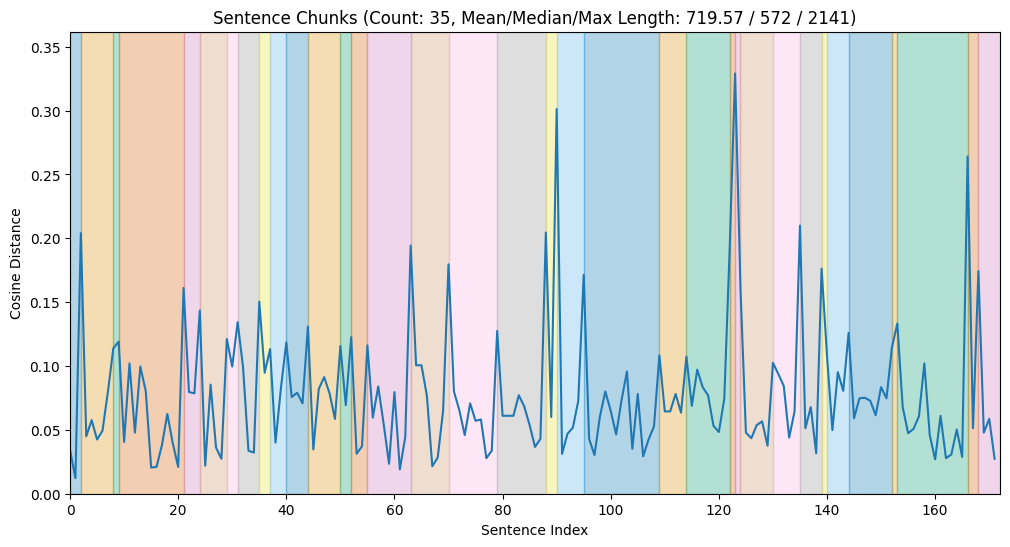

In [7]:
import numpy as np


PERCENTILE = 80

threshold = np.percentile(distances, PERCENTILE)
threshold_idxs = np.where(distances > threshold)[0]

chunk_starts = [0] + list(threshold_idxs + 1)
chunk_ends = list(threshold_idxs + 1) + [len(distances)]
chunks = list(zip(chunk_starts, chunk_ends))

plot_groups(newline_spans, distances, chunks)

In [8]:
chunk_spans = [(newline_spans[start][0], newline_spans[end - 1][1]) for start, end in chunks]
print_spans(chunk_spans)

Count: 35, Mean Length: 719.97, Median Length: 528, Max Length: 2328

Chunk #0 (length=527)
At Fiverr we care about your privacy.
We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.
We do not disclose it to ot
...
ng - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.


Chunk #1 (length=1279)
We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser
...
her than through your user profile on the Site.
  Your personal information may be stored in systems based around the world, and may be processed by third party service providers acting on our behalf.


Chunk #2 (length=157)
These providers may be based in countries that do

### Examine Recursive Splitting Strategy

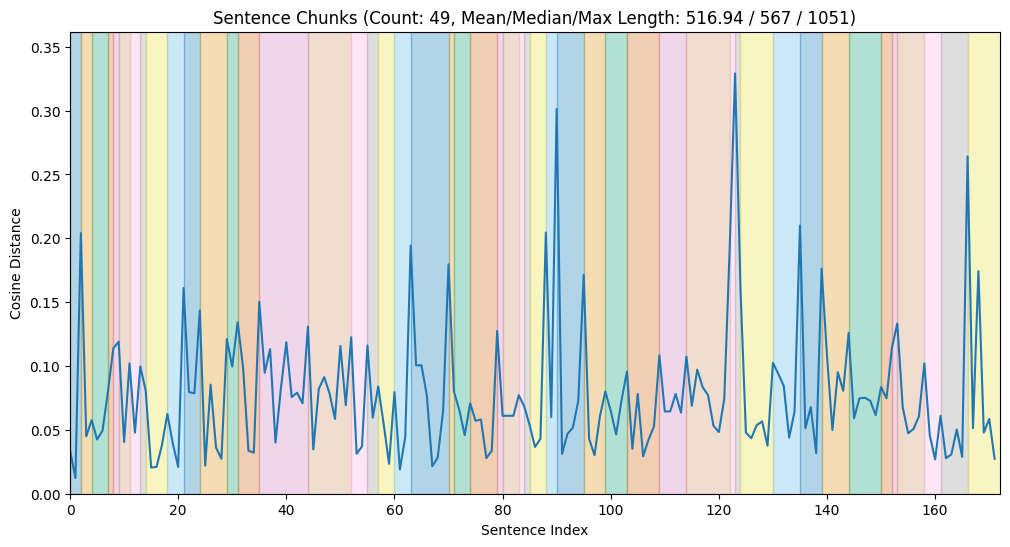

In [9]:
import numpy as np


def split_recursive(spans, distances, max_span):
    distances = np.asarray(distances)
    span_spans = []
    def dfs(start, end):
        lo = spans[start][0]
        hi = spans[end - 1][1]
        if (end - start <= 1) or (hi - lo <= max_span):
            span_spans.append((start, end))
        else:
            split_idx = start + np.argmax(distances[start:end - 1]) + 1
            dfs(start, split_idx)
            dfs(split_idx, end)
    dfs(0, len(spans))
    return span_spans

chunks_recursive = split_recursive(newline_spans, distances, 1000)
plot_groups(newline_spans, distances, chunks_recursive)

In [10]:
chunk_recursive_spans = [(newline_spans[start][0], newline_spans[end - 1][1]) for start, end in chunks_recursive]
print_spans(chunk_recursive_spans)

Count: 49, Mean Length: 517.27, Median Length: 537, Max Length: 990

Chunk #0 (length=527)
At Fiverr we care about your privacy.
We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.
We do not disclose it to ot
...
ng - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.


Chunk #1 (length=478)
We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser
...
more personalized browsing experience.
  We will not share information that you provide us in the process of the registration - including your contact information - except as described in this Policy.


Chunk #2 (length=645)
Information that you choose to publish on the Site 